In [1]:
import os
import itertools
from collections import defaultdict
import numpy as np
import tskit as tsk
import pyslim as psl
import matplotlib.pyplot as plt

In [2]:
def load_and_recapitate(f, mu=None, seed=None):
    if seed is None:
        seed = np.random.randint(0, 2**32-1, 1)
    tr = psl.load(f)
    md = tr.metadata['SLiM']['user_metadata']
    rbp, N = [md[k][0] for k in ('rbp', 'N')]
    rtr = tr.recapitate(recombination_rate=rbp, random_seed=seed)
    if mu is not None:
        rtr.tables.mutations.clear()
        rtr = msp.sim_mutations(rtr, rate=mu, keep=False, random_seed=seed, model=msp.InfiniteSites())
    return rtr

In [3]:
# simulation parameters shared between sims
region_length = 1000000
N = 500
inversion = (250000, 749999)

### Overdominant Inversions

We need only one replicate to see the characterstic inversion patterns in diversity here.

In [4]:
files = {rbp: f"inversion_{rbp}.trees" for rbp in [1e-7, 1e-8]}
ts = {rbp: load_and_recapitate(file) for rbp, file in files.items()}

In [5]:
# example of how we could access these via metadata
#region_length = ts[1e-07].metadata['SLiM']['user_metadata']['region_length'][0]
#inversion = ts[1e-07].metadata['SLiM']['user_metadata']['inversion_coords']
#N = ts[1e-07].metadata['SLiM']['user_metadata']['N'][0]
pis = {rbp: ts.diversity(windows='trees', mode='branch') for rbp, ts in ts.items()}
xs = {rbp: np.cumsum([t.span for t in ts.trees()]) for rbp, ts in ts.items()}

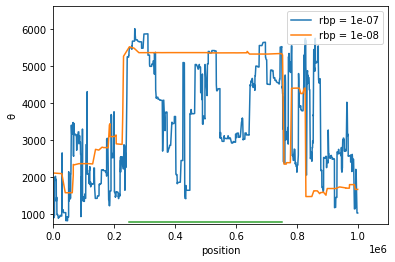

In [6]:
fig, ax = plt.subplots()
for rbp in pis:
    ax.plot(xs[rbp], pis[rbp], label=f'rbp = {rbp}')
y = np.fromiter(itertools.chain(*pis.values()), dtype='f')
min_y, max_y = np.min(y), np.max(y)
ax.plot(inversion, 2*[0.95*min_y])
ax.set_xlim(0, region_length*1.1)
ax.set_ylim(min_y*0.9, max_y*1.1)
ax.set_ylabel("θ")
ax.set_xlabel("position")
plt.legend(loc='upper right')
plt.savefig('single_runs.png')

### Neutral Inversions (Conditional on Establishment)

In [7]:
simdir = 'cond_results'
tree_files = os.listdir(simdir)
cond_trees = [load_and_recapitate(os.path.join(simdir, f)) for f in tree_files if f.endswith('trees')]

Group and summarize the trees by `rbp` and `establish_freq`.

In [8]:
results = defaultdict(list)

region_length = 1000000
windows = np.arange(0, region_length+1, 2000)

for tree in cond_trees:
    md = tree.metadata['SLiM']['user_metadata']
    pi = tree.diversity(windows=windows, mode='branch')
    results[(md['establish_freq'][0], md['rbp'][0])].append(pi)

In [9]:
# merge everything into an array
merged = defaultdict(dict)
for params, data in results.items():
    est_freq, rbp = params
    merged[est_freq][rbp] = np.stack(data).mean(axis=0)

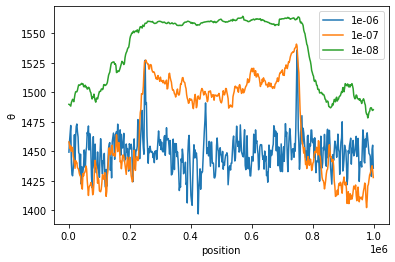

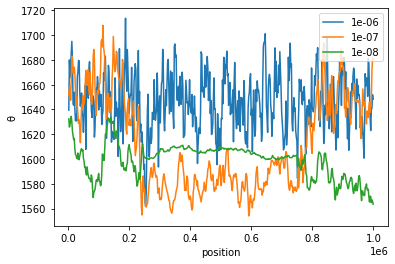

In [11]:
est_freqs = [0.5, 0.8]
for est_freq in est_freqs:
    rbps = [1e-6, 1e-7, 1e-8]
    fig, ax = plt.subplots()
    midpoints = 0.5*(windows[1:] + windows[:-1])
    for rbp in rbps:
        ax.plot(midpoints, merged[est_freq][rbp], label=rbp)
        ax.set_ylabel("θ")
        ax.set_xlabel("position")
        plt.legend(loc='upper right')
    plt.savefig(f'conditioned_{est_freq}.png')